In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision.transforms as T
from torch.utils.data import DataLoader

import numpy as np

from itertools import repeat

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
from modules import WaveletNet, LazyWavelet, Lifting

# Generate toy dataset -- sample from bivariate normal distribution with mean 0.

In [6]:
batch_size = 512
dimensionality = 2
loc = torch.zeros(dimensionality).double()
scale_tril = torch.tensor(np.tril((np.random.rand(dimensionality, dimensionality)-.5)*2)).double()
dist = D.MultivariateNormal(loc=loc, scale_tril=scale_tril)
x_sample = dist.sample((batch_size,)).float()

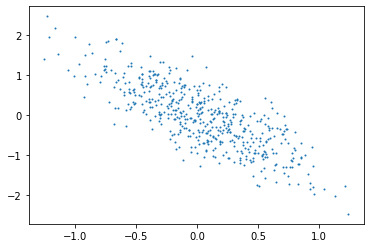

In [7]:
plt.scatter(x_sample[:, 0], x_sample[:, 1], s=1)

# Create normalizing flow model

In [8]:
model = WaveletNet(n_lifting_steps=5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

step = 0

In [9]:
dataloader = DataLoader(dataset=torch.cat(list(repeat(x_sample, 1_000))), batch_size=batch_size)

# Train model

In [10]:
for i, x in enumerate(dataloader):
    global step
    step += 1
    loss = - model.log_prob(x).mean()
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 50)
    optimizer.step()
    if i % 100 == 0:
        with torch.no_grad():
            print(f"Step {i}. Loss: {loss}")

Step 0. Loss: 2.256124496459961
Step 100. Loss: 2.1270782947540283
Step 200. Loss: 2.0799379348754883
Step 300. Loss: 2.061408042907715
Step 400. Loss: 2.059471607208252
Step 500. Loss: 2.0594162940979004
Step 600. Loss: 2.059415817260742
Step 700. Loss: 2.059415817260742
Step 800. Loss: 2.059415817260742
Step 900. Loss: 2.059415817260742


# Visualize the distribution that the model fits

## Sample latent variables

In [11]:
with torch.no_grad():
    z = model.base_dist.sample((512,2,1))

In [12]:
with torch.no_grad():
    x = model.inverse(z)[0].detach().numpy()
    lazy = LazyWavelet()
    z_flat = lazy.inverse(z)[0].detach().numpy()

# Plot latent variables

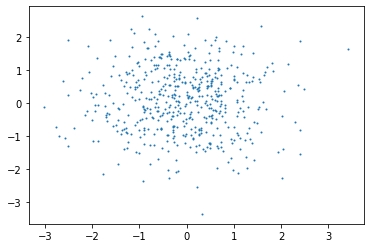

In [13]:
 plt.scatter(z_flat[:,0], z_flat[:,1], s=1)

## Plot model fit (transformed latent variables)

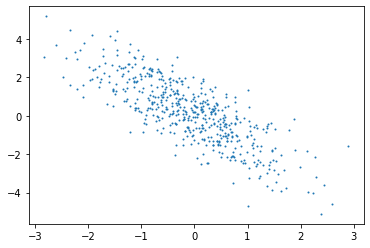

In [14]:
plt.scatter(x[:,0], x[:,1], s=1)